# Heart Disease Prediction

## Introduction

Welcome to the Heart Disease Prediction notebook! In this session, we will explore a dataset related to heart disease and build a machine learning model to predict the likelihood of a patient having heart disease. 

## 1 Dataset Exploration and Understanding

To begin our journey, let's gain a thorough understanding of the dataset. We are dealing with a dataset that comprises 14 attributes, each providing valuable insights into a patient's health. From the patient's age and gender to specific medical indicators such as blood pressure and cholesterol levels, these attributes collectively form the basis for predicting heart disease.

###  1.1 Variable Information

Before diving into the analysis, let's understand the variables in our dataset:

1. Age (age): Patient's age in years.

2. Sex (sex): Gender of the patient.
    Values: 1 = Male, 0 = Female

3. Chest Pain Type (cp): Type of chest pain experienced.
    Values: 1 = Typical angina, 2 = Atypical angina, 3 = Non-anginal pain, 4 = Asymptomatic

4. Resting Blood Pressure (trestbps): Blood pressure on admission in mm Hg.

5. Serum Cholesterol (chol): Serum cholesterol level in mg/dl.

6. Fasting Blood Sugar (fbs): Fasting blood sugar level.
    Values: 1 = >120 mg/dl, 0 = <=120 mg/dl

7. Resting Electrocardiographic Results (restecg): Results of resting electrocardiogram.
    Values: 0 = Normal, 1 = ST-T wave abnormality, 2 = Probable or definite left ventricular hypertrophy

8. Maximum Heart Rate Achieved (thalach): Maximum heart rate during examination.

9. Exercise-Induced Angina (exang): Presence of exercise-induced angina.
    Values: 1 = Yes, 0 = No

10. ST Depression Induced by Exercise Relative to Rest (oldpeak): ST depression induced by exercise relative to rest.

11. Slope of the Peak Exercise ST Segment (slope): Slope of the peak exercise ST segment.
    Values: 1 = Upsloping, 2 = Flat, 3 = Downsloping

12. Number of Major Vessels Colored by Fluoroscopy (ca): Number of major vessels colored by fluoroscopy. A higher count may indicate a greater degree of vessel involvement or narrowing, which can be associated with more advanced stages of coronary artery disease.

13. Thalassemia (thal): Type of thalassemia.
    Values: 3 = Normal, 6 = Fixed defect, 7 = Reversible defect

14. Diagnosis of Heart Disease (num): Diagnosis based on angiographic disease status.
    Values: 0 = < 50% diameter narrowing, 1 = > 50% diameter narrowing (in any major vessel)

### 1.2 Dataset information: 
https://archive.ics.uci.edu/dataset/45/heart+disease


### 1.3 Introductory Paper

International application of a new probability algorithm for the diagnosis of coronary artery disease.
By R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sandhu, K. Guppy, S. Lee, V. Froelicher. 1989

Published in American Journal of Cardiology

### 1.4 Import Dataset and Libraries

In [ ]:
# Install libraries
! pip install ucimlrepo
! pip install shap

In [ ]:
# Import necessary libraries
import warnings
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
import shap

# Define color palette for plot
palette = ["#87CEEB", "#FFA07A"]

# Silence warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore",
                        message="is_categorical_dtype is deprecated")

In [ ]:
# import dataset
heart_disease = fetch_ucirepo(name='Heart Disease')
df = heart_disease['data']['original'] # access data

# Print first 5 rows of our data
df.head()

### 1.5 Feature Renaming

To enhance interpretability and align with medical terminology, we will rename the columns using more descriptive names. This not only makes the dataset more understandable but also improves the overall clarity of our analysis.

In [ ]:
# Define a dictionary with the new column names
new_column_names = {
    'age': 'Age',
    'sex': 'Sex',
    'cp': 'ChestPainType',
    'trestbps': 'RestingBloodPressure',
    'chol': 'SerumCholesterol',
    'fbs': 'FastingBloodSugar',
    'restecg': 'RestingECG',
    'thalach': 'MaxHeartRate',
    'exang': 'ExerciseInducedAngina',
    'oldpeak': 'STDepression',
    'slope': 'SlopeSTSegment',
    'ca': 'NumMajorVessels',
    'thal': 'Thalassemia',
    'num': 'HeartDiseaseDiagnosis'
}

# Rename the columns using the dictionary
df.rename(columns=new_column_names, inplace=True)

# Print first 5 rows of our data
df.head()

### 1.6 Target Binarization

The target variable is binarized, simplifying the problem into a binary classification task. Values less than 1 are assigned 1 (positive diagnosis), while others are assigned 0 (negative diagnosis).

In [ ]:
# Displaying the distribution of the original target variable (`HeartDiseaseDiagnosis`) provides insights into the balance between positive and negative diagnoses.
df['HeartDiseaseDiagnosis'].value_counts()

# Binarize the target variable
df['HeartDiseaseDiagnosis'] = np.int64(df['HeartDiseaseDiagnosis'] < 1)

Distribution After Binarization

Examining the distribution after binarization shows how the conversion has altered the balance between positive and negative diagnoses.

In [ ]:
sns.countplot(x="HeartDiseaseDiagnosis", data=df, palette=palette)
plt.xlabel("Heart Disease (0 = False, 1= True)")
plt.show()

### 1.7. Exploratory Data Analysis

In [ ]:
sns.countplot(x='Sex', data=df, palette="mako_r")
plt.xlabel("Sex (0 = female, 1= male)")
plt.show()

In [ ]:
pd.crosstab(df.Sex,df.HeartDiseaseDiagnosis).plot(kind="bar",figsize=(15,6),color=palette)
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["Disease", "Not Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.scatter(x=df.Age[df.HeartDiseaseDiagnosis==1], y=df.MaxHeartRate[(df.HeartDiseaseDiagnosis==1)], c=palette[1])
plt.scatter(x=df.Age[df.HeartDiseaseDiagnosis==0], y=df.MaxHeartRate[(df.HeartDiseaseDiagnosis==0)], c=palette[0])
plt.legend(["Disease", "Not Disease"])
plt.xlabel("Age")
plt.ylabel("Maximum Heart Rate")
plt.show()

### 2 Feature Preprocessing

### 2.1 Categorical Encodingm

In [ ]:
# Define the mapping for each categorical variable
ChestPainType_mapping = {1: 'Typical angina', 2: 'Atypical angina', 3: 'Non-anginal pain', 4: 'Asymptomatic'}
Thalassemia_mapping = {3.0: 'Normal', 6.0: 'Fixed defect', 7.0: 'Reversible defect'}
SlopeSTSegment_mapping = {1: 'Upsloping', 2: 'Flat', 3: 'Downsloping'}

# Replace the values in the original DataFrame
df['ChestPainType'] = df['ChestPainType'].map(ChestPainType_mapping)
df['Thalassemia'] = df['Thalassemia'].map(Thalassemia_mapping)
df['SlopeSTSegment'] = df['SlopeSTSegment'].map(SlopeSTSegment_mapping)

In [ ]:
pd.crosstab(df.SlopeSTSegment,df.HeartDiseaseDiagnosis).plot(kind="bar",figsize=(15,6),color=palette)
plt.title('Heart Disease Frequency for Slope')
plt.xlabel('The Slope of The Peak Exercise ST Segment ')
plt.xticks(rotation = 0)
plt.legend(["Not Disease", "Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
pd.crosstab(df.FastingBloodSugar,df.HeartDiseaseDiagnosis).plot(kind="bar",figsize=(15,6),color=palette)
plt.title('Heart Disease Frequency According To FBS')
plt.xlabel('FBS - (Fasting Blood Sugar > 120 mg/dl) (1 = true; 0 = false)')
plt.xticks(rotation = 0)
plt.legend(["Not Disease", "Disease"])
plt.ylabel('Frequency of Disease or Not')
plt.show()

In [ ]:
pd.crosstab(df.ChestPainType,df.HeartDiseaseDiagnosis).plot(kind="bar",figsize=(15,6),color=palette)
plt.title('Heart Disease Frequency According To Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.xticks(rotation = 0)
plt.legend(["Not Disease", "Disease"])
plt.ylabel('Frequency of Disease or Not')
plt.show()

Creating Dummy Variables
Since 'cp', 'thal' and 'slope' are categorical variables we'll turn them into dummy variables.

**Chest Pain Type (cp)**: Type of chest pain experienced.
        Values: 1 = Typical angina, 2 = Atypical angina, 3 = Non-anginal pain, 4 = Asymptomatic

**Thalassemia (thal)**: Type of thalassemia.
        Values: 3 = Normal, 6 = Fixed defect, 7 = Reversible defect

**Slope of the Peak Exercise ST Segment (slope)**: Slope of the peak exercise ST segment.
        Values: 1 = Upsloping, 2 = Flat, 3 = Downsloping


In [ ]:
# Convert variables to appropriate data types
categorical_vars = ['ChestPainType', 'Thalassemia', 'SlopeSTSegment']
df[categorical_vars] = df[categorical_vars].astype(str)

### 2.2 Missing values

In [ ]:
df.replace('nan', np.nan, inplace=True)

In [ ]:
# Use get_dummies and assign column names
dummies = pd.get_dummies(df[categorical_vars], prefix=categorical_vars,dummy_na = False, drop_first=True).astype(np.int64)
df = pd.concat([df, dummies], axis=1)
df = df.drop(columns=categorical_vars)

In [ ]:
# Check for missing values in all columns
missing_values = df.isna().sum()

# Display the count of missing values in each column
print(missing_values)

In [ ]:
df.dropna(inplace=True)
# Display the count of missing values in each column
missing_values = df.isna().sum()
print(missing_values)

## 3. Model

### 3.1 Data Preparation for Machine Learning

**Separate Features and Target Variable**

The dataset is divided into features (X) and the target variable (y). Features (`X`) include all columns except for the target variable, while the target variable (`y`) is isolated.


In [ ]:
# Separate features and target variable
X = df.drop('HeartDiseaseDiagnosis', axis=1)
y = df['HeartDiseaseDiagnosis']

**Perform Hold-out Split**

The dataset undergoes a hold-out split using train_test_split from scikit-learn. This partitions the data into training (X_train, y_train) and testing (X_test, y_test) sets, facilitating model training and evaluation.

# Perform a hold-out split (adjust test_size as needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3.2 Create and Train the Random Forest Model

Instantiate a Random Forest classifier with the specified hyperparameters and train the model using the training data.
Define hyperparameters for the Random Forest model. Students can experiment with and modify these values to observe their impact on model performance.


**max_depth**: Controls the maximum depth of each decision tree. A higher value captures more complex patterns but may lead to overfitting.

**n_estimators**: Sets the number of decision trees in the Random Forest ensemble. 

In [ ]:
# Set hyperparameters (students can modify these)
max_depth = 10
n_estimators = 100

In [ ]:
# Create and train the Random Forest model
model = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=42)
trained_model = model.fit(X_train, y_train)

### 4 Model Evaluation and Visualization

### 4.1 Confusion Matrix  

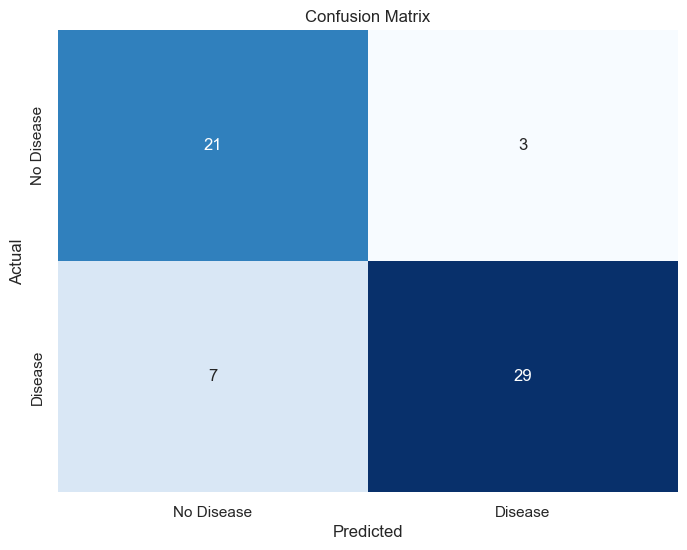

In [144]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 4.2 Classification Report and ROC Curve

Assess the model's classification performance using the classification report and visualize the Receiver Operating Characteristic (ROC) curve with the Area Under the Curve (AUC) score.

In [146]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.88      0.81        24
           1       0.91      0.81      0.85        36

    accuracy                           0.83        60
   macro avg       0.83      0.84      0.83        60
weighted avg       0.84      0.83      0.83        60



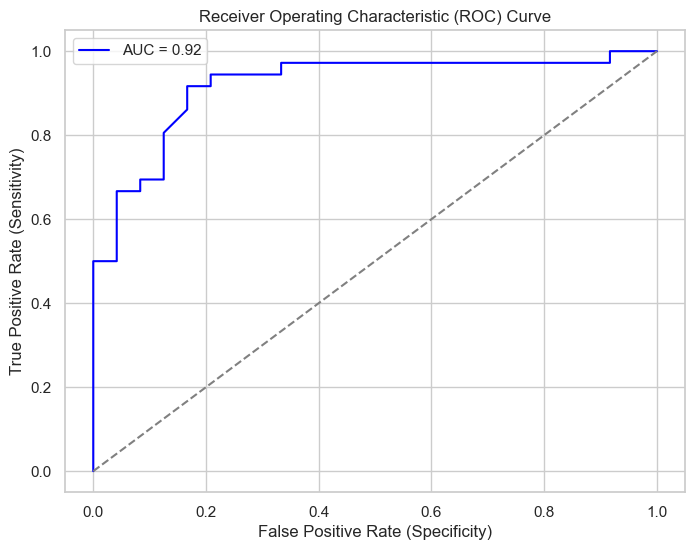

In [147]:
# Calculate AUC (Area Under the Curve)
y_probs = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_probs)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.show()

## 5. Feature Importance Analysis and Interpretability

Feature Importance Analysis involves understanding which factors have the most influence on a predictive model's decisions. In clinical practice, these factors may represent crucial patient parameters, biomarkers, or clinical indicators.

**Importance in Clinical Practice**:
- Reliability: Identifying influential features enhances the reliability of diagnostic or predictive models.
- Interpretability: Knowing which factors matter most improves the interpretability of the model's decisions.
- Clinical Relevance: Provides actionable insights for healthcare professionals to focus on key factors in patient assessment.


### 5.1 Feature importance

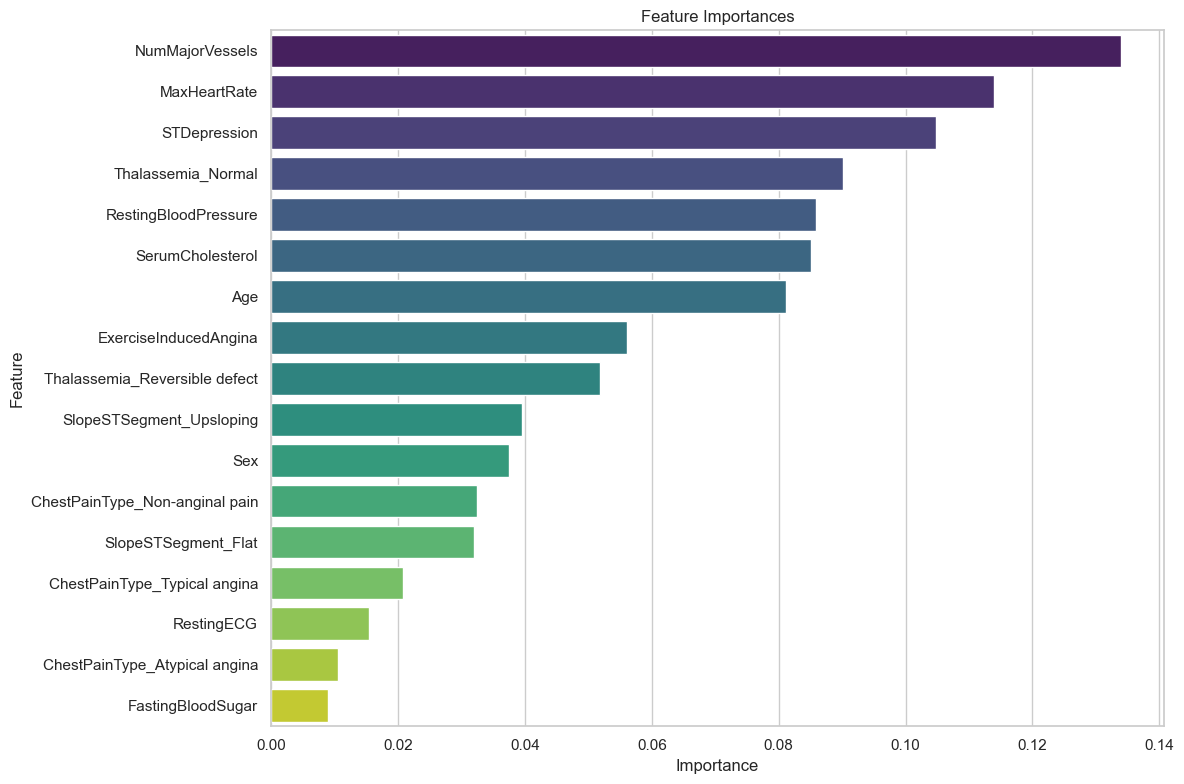

In [151]:
# Display feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': trained_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display feature importances with a bar plot using seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette="viridis")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()


To validate the reasonability of the feature importance analysis, let's conduct an exploratory analysis of the most relevant features. This additional investigation will provide insights into the patterns and characteristics of these features, helping us ensure their clinical relevance and alignment with our expectations.

In [ ]:
df['NumMajorVessels'].value_counts()

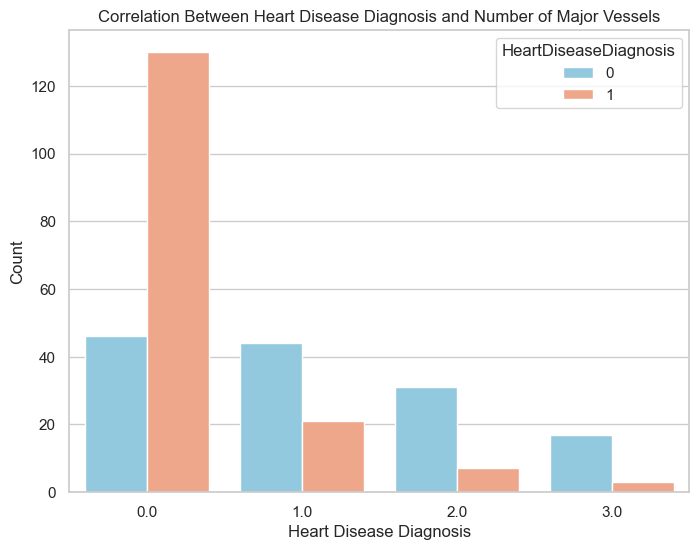

In [152]:
# Create a contingency table
contingency_table = pd.crosstab(df['HeartDiseaseDiagnosis'], df['NumMajorVessels'])

# Plot a stacked bar chart
plt.figure(figsize=(8, 6))
sns.countplot(x='NumMajorVessels', hue='HeartDiseaseDiagnosis', data=df, palette=palette)
plt.title('Correlation Between Heart Disease Diagnosis and Number of Major Vessels')
plt.xlabel('Heart Disease Diagnosis')
plt.ylabel('Count')
plt.show()


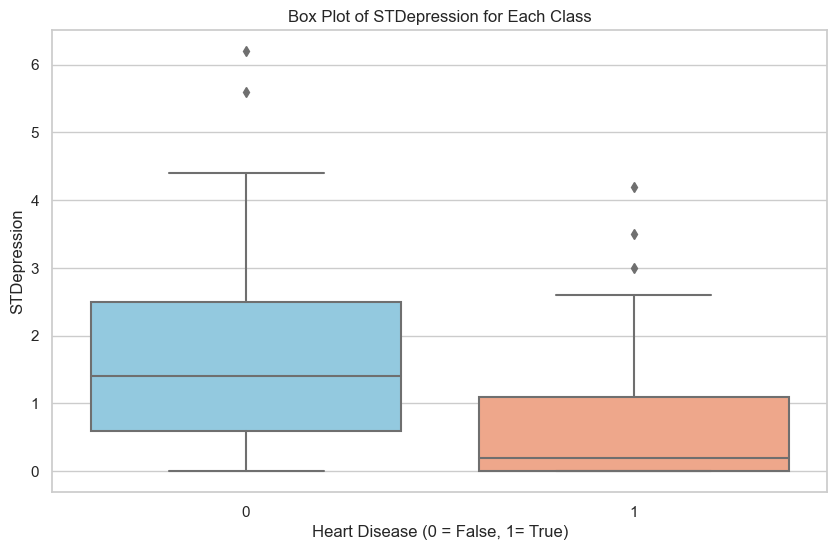

In [153]:
# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='HeartDiseaseDiagnosis', y='STDepression', data=df, palette=palette)

# Add labels and title
plt.xlabel('Heart Disease (0 = False, 1= True)')
plt.ylabel('STDepression')
plt.title('Box Plot of STDepression for Each Class')

# Show the plot
plt.show()

###  5.2 Further Interpretability Analysis

For a more in-depth validation, let's conduct further analysis using SHAP (SHapley Additive exPlanations). This approach will offer detailed insights into how each relevant feature contributes to individual model predictions, providing a robust understanding of the model's decision-making process and reinforcing the interpretability of our findings.

In [ ]:
# load JS visualization code to notebook
shap.initjs()
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

patient_number = 2

# Force plot with custom colors
shap.force_plot(explainer.expected_value[1], shap_values[1][patient_number], X_test.iloc[patient_number, :], plot_cmap=palette[::-1])

In [ ]:
patient_number = np.argmin(y_probs)

# Force plot with custom colors
shap.force_plot(explainer.expected_value[1], shap_values[1][patient_number], X_test.iloc[patient_number, :], plot_cmap=palette[::-1])

In [ ]:
#Create a beeswarm plot to visualize the impact of features on predictions.
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, show=False)
plt.title("SHAP Summary Plot - Impact on Heart Disease Diagnosis")
plt.xlabel("Impact on Model Output (Proximity to Heart Disease)")
plt.ylabel("Feature")
plt.show()
plt.show()

Sex (sex): Gender of the patient. Values: 1 = Male, 0 = Female

Exercise-Induced Angina (exang): Presence of exercise-induced angina.
    Values: 1 = Yes, 0 = No